### Bases on exp3 ==>huggingface

In [1]:
import os, time, pickle, shutil
import pandas as pd
import numpy as np

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from torch import autocast

import torchvision.transforms as transforms

import timm
from timm.models import create_model
from timm.utils import ModelEmaV2

from timm.optim import create_optimizer_v2


from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from torchmetrics import MetricCollection



import matplotlib.pyplot as plt


################## Settings #############################
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = True

################## Data Paths ##########################
MODEL_DIR = "./DINO_meta_embedding_vit_base_patch14_reg4_dinov2.lvd142m/"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
TRAIN_DATA_DIR = "./Master Thesis/Dataset/SnakeCLEF2023-train-large_size/" # train imgs. path on DGX1
ADD_TRAIN_DATA_DIR = "./Master Thesis/Dataset/HMP" # train imgs. path on DGX1

VAL_DATA_DIR = "./Dataset/SnakeCLEF2023-val-large_size/" # val imgs. path on DGX1

TRAINDATA_CONFIG = "/home/mohammadreza.bagherifar/Master Thesis/Dataset/SnakeCLEF2023-TrainMetadata-iNat.csv"
ADD_TRAINDATA_CONFIG = "/home/mohammadreza.bagherifar/Master Thesis/Dataset/SnakeCLEF2023-TrainMetadata-HMP.csv"


VALIDDATA_CONFIG = "/home/mohammadreza.bagherifar/Master Thesis/Dataset/SnakeCLEF2023-ValMetadata.csv"
CCM = "/home_remote/docker_home/Master Thesis/Dataset/code_class_mapping_obid.csv"

NUM_CLASSES = 1784

################## Hyperparameters ########################
NUM_EPOCHS = 40
WARMUP_EPOCHS = 5 # num. epochs only training classification head of model
RESUME_EPOCH = 0 


LEARNING_RATE = {
    'cnn': 1e-05,
    'embeddings': 1e-04,
    'classifier': 1e-04,
}

BATCH_SIZE = {
    'train': 16, 
    'valid': 16, 
    'grad_acc': 4, # gradient acc. steps with 'train' of batch sizes, global batch size = 'grad_acc' * 'train'
}

BATCH_SIZE_AFTER_WARMUP = {
    'train': 16, 
    'valid': 16, 
    'grad_acc': 4, # gradient acc. steps with 'train' of batch sizes, global batch size = 'grad_acc' * 'train'
}

TRANSFORMS = {
    'IMAGE_SIZE_TRAIN': 518,
    'IMAGE_SIZE_VAL': 518,
    'RandAug' : {
        'm': 7,
        'n': 2
    }
}

############# Checkpoints ####################
CHECKPOINTS = {
    'fe_cnn': None, # iNaturalist pre-trained model checkpoints available at "https://huggingface.co/BBracke/convnextv2_base.inat21_384"
    'model': None,
    'optimizer': None,
    'scaler': None,
    }

# ####### Embedding Token Mappings ########################
META_SIZES = {'endemic': 2, 'code': 212}
EMBEDDING_SIZES = {'endemic': 64, 'code': 64}

CODE_TOKENS = pickle.load(open("/home/mohammadreza.bagherifar/Master Thesis/Models/ResNet/meta_code_tokens.p", "rb"))
ENDEMIC_TOKENS = pickle.load(open("/home/mohammadreza.bagherifar/Master Thesis/Models/ResNet/meta_endemic_tokens.p", "rb"))


In [10]:
##################### Dataset & AugTransforms #####################################
# ### dataset & loaders
class SnakeTrainDataset(Dataset):
    def __init__(self, data, ccm, transform=None):
        self.data = data
        self.transform = transform # Image augmentation pipeline
        self.code_class_mapping = ccm
        self.code_tokens = CODE_TOKENS
        self.endemic_tokens = ENDEMIC_TOKENS

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        obj = self.data.iloc[index] # get instance
        label = obj.class_id # get label
        code = obj.code if obj.code in self.code_tokens.keys() else "unknown"
        endemic = obj.endemic if obj.endemic in self.endemic_tokens.keys() else False # get endemic metadata

        img = Image.open(obj.image_path).convert("RGB") # load image
        ccm = torch.tensor(self.code_class_mapping[code].to_numpy()) # code class mapping
        meta = torch.tensor([self.code_tokens[code], self.endemic_tokens[endemic]]) # metadata tokens

        # img. augmentation
        img = self.transform(img)

        return (img, label, ccm, meta)


# valid data preprocessing pipeline
def get_val_preprocessing(img_size):
    print(f'IMG_SIZE_VAL: {img_size}')
    return transforms.Compose([
                transforms.Resize(int(img_size * 1.25)), # Expand IMAGE_SIZE before random crop
                transforms.Compose([
                    transforms.FiveCrop((img_size, img_size)), # this is a list of PIL Images
                    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])) # returns a 4D tensor
                ]),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

class IdentityTransform:
    def __call__(self, x):
        return x


# train data augmentation/ preprocessing pipeline
def get_train_augmentation_preprocessing(img_size, rand_aug=False):
    print(f'IMG_SIZE_TRAIN: {img_size}, RandAug: {rand_aug}')
    return transforms.Compose([
                transforms.Resize(int(img_size * 1.25)), # Expand IMAGE_SIZE before random crop
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomCrop((img_size, img_size)), # Random Crop to IMAGE_SIZE
                transforms.RandAugment(num_ops=TRANSFORMS['RandAug']['n'], magnitude=TRANSFORMS['RandAug']['m']) if rand_aug else IdentityTransform(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])


def get_datasets(train_transfroms, val_transforms):
    # load CSVs
    nan_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']
    train_data = pd.read_csv(TRAINDATA_CONFIG, na_values=nan_values, keep_default_na=False)
    valid_data = pd.read_csv(VALIDDATA_CONFIG, na_values=nan_values, keep_default_na=False)


    # add additional data
    if ADD_TRAINDATA_CONFIG:
        add_train_data = pd.read_csv(ADD_TRAINDATA_CONFIG, na_values=nan_values, keep_default_na=False)
        train_data = pd.concat([train_data, add_train_data], axis=0)

    # limit data size
    #train_data = train_data.head(1000)
    #valid_data = valid_data.head(1000)
    print(f'train data shape: {train_data.shape}')

    # shuffle
    train_data = train_data.sample(frac=1, random_state=1).reset_index(drop=True)
    valid_data = valid_data.sample(frac=1, random_state=1).reset_index(drop=True)

    # load transposed version of CCM table
    ccm = pd.read_csv(CCM, na_values=nan_values, keep_default_na=False)
    
    missing_ccm_codes = valid_data.loc[~valid_data['code'].isin(train_data['code'].unique()), 'code'].unique().tolist()
    missing_ccm_codes.extend(add_train_data.loc[~add_train_data['code'].isin(train_data['code'].unique()), 'code'].unique().tolist())
    for code in missing_ccm_codes:
        ccm[code] = np.ones(NUM_CLASSES, dtype=int)

    # create datasets
    train_dataset = SnakeTrainDataset(train_data, ccm, transform=train_transfroms)
    valid_dataset = SnakeTrainDataset(valid_data, ccm, transform=val_transforms)

    return train_dataset, valid_dataset#, TCLASS_WEIGHTS, VCLASS_WEIGHTS


def get_dataloaders(imgsize_train, imgsize_val, rand_aug):
    # get train, valid augmentation & preprocessing pipelines
    train_aug_preprocessing = get_train_augmentation_preprocessing(imgsize_train, rand_aug)
    val_preprocessing = get_val_preprocessing(imgsize_val)
    # prepare the datasets
    train_dataset, valid_dataset = get_datasets(train_transfroms=train_aug_preprocessing, val_transforms=val_preprocessing)
    train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE['train'], num_workers=2, drop_last=True, pin_memory=True)
    valid_loader = DataLoader(dataset=valid_dataset, shuffle=False, batch_size=BATCH_SIZE['valid'], num_workers=2, drop_last=False, pin_memory=True)

    return train_loader, valid_loader


In [11]:
# #################### plot train history #########################

def plot_history(logs):
    fig, ax = plt.subplots(3, 1, figsize=(8, 12))

    ax[0].plot(logs['loss'], label="train data")
    ax[0].plot(logs['val_loss'], label="valid data")
    ax[0].legend(loc="best")
    ax[0].set_ylabel("loss")
    ax[0].set_ylim([0, -np.log(1/NUM_CLASSES)])
    #ax[0].set_xlabel("epochs")
    ax[0].set_title("train- vs. valid loss")

    ax[1].plot(logs['acc'], label="train data")
    ax[1].plot(logs['val_acc'], label="valid data")
    ax[1].legend(loc="best")
    ax[1].set_ylabel("accuracy")
    ax[1].set_ylim([0, 1.01])
    #ax[1].set_xlabel("epochs")
    ax[1].set_title("train- vs. valid accuracy")

    ax[2].plot(logs['f1'], label="train data")
    ax[2].plot(logs['val_f1'], label="valid data")
    ax[2].legend(loc="best")
    ax[2].set_ylabel("f1")
    ax[2].set_ylim([0, 1.01])
    ax[2].set_xlabel("epochs")
    ax[2].set_title("train- vs. valid f1")

    fig.savefig(f'{MODEL_DIR}model_history.svg', dpi=150, format="svg")
    plt.show()


In [12]:
# #################### Model #####################################

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv_backbone =timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m', pretrained=True, num_classes=0)
        if CHECKPOINTS['fe_cnn']:
            self.conv_backbone.load_state_dict(torch.load(CHECKPOINTS['fe_cnn'], map_location='cpu'), strict=True)
            print(f"use FE_CHECKPOINTS: {CHECKPOINTS['fe_cnn']}")
            torch.cuda.empty_cache()

    def forward(self, img):
        conv_features = self.conv_backbone(img)
        return conv_features


class MetaEmbeddings(nn.Module):
    def __init__(self, embedding_sizes: dict, meta_sizes: dict, dropout: float = None):
        super(MetaEmbeddings, self).__init__()
        self.endemic_embedding = nn.Embedding(meta_sizes['endemic'], embedding_sizes['endemic'], max_norm=1.0)
        self.code_embedding = nn.Embedding(meta_sizes['code'], embedding_sizes['code'], max_norm=1.0)

        self.dim_embedding = sum(embedding_sizes.values())
        self.embedding_net = nn.Sequential(
            nn.Linear(in_features=self.dim_embedding, out_features=self.dim_embedding, bias=True),
            nn.GELU(),
            nn.LayerNorm(self.dim_embedding, eps=1e-06),
            nn.Dropout(p=dropout, inplace=False) if dropout else nn.Identity(),
            nn.Linear(in_features=self.dim_embedding, out_features=self.dim_embedding, bias=True),
            nn.GELU(),
            nn.LayerNorm(self.dim_embedding, eps=1e-06),
        )

    def forward(self, meta):
        code_feature = self.code_embedding(meta[:,0])
        endemic_feature = self.endemic_embedding(meta[:,1])

        embeddings = torch.cat([code_feature, endemic_feature], dim=-1)
        embedding_features = self.embedding_net(embeddings)

        return embedding_features


class Classifier(nn.Module):
    def __init__(self, num_classes: int, dim_embeddings: int, dropout: float = None):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout, inplace=False) if dropout else nn.Identity()
        self.classifier = nn.Linear(in_features=dim_embeddings, out_features=num_classes, bias=True)

    def forward(self, embeddings):
        dropped_feature = self.dropout(embeddings)
        outputs = self.classifier(dropped_feature)

        return outputs


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.embedding_net = MetaEmbeddings(embedding_sizes=EMBEDDING_SIZES, meta_sizes=META_SIZES, dropout=0.25)
        self.classifier = Classifier(num_classes=NUM_CLASSES, dim_embeddings=768+128, dropout=0.25)  # Adjusted for DenseNet121

    def forward(self, img, meta):
        img_features = self.feature_extractor(img)
        meta_features = self.embedding_net(meta)
        cat_features = torch.concat([img_features, meta_features], dim=-1)
        classifier_outputs = self.classifier(cat_features)
        
        return classifier_outputs


def load_checkpoints(model=None, optimizer=None, scaler=None):
    if CHECKPOINTS['model'] and model is not None:
        model.load_state_dict(torch.load(CHECKPOINTS['model'], map_location='cpu'))
        print(f"use model checkpoints: {CHECKPOINTS['model']}")
    if CHECKPOINTS['optimizer'] and optimizer is not None:
        optimizer.load_state_dict(torch.load(CHECKPOINTS['optimizer'], map_location='cpu'))
        print(f"use optimizer checkpoints: {CHECKPOINTS['optimizer']}")
    if CHECKPOINTS['scaler'] and scaler is not None:
        scaler.load_state_dict(torch.load(CHECKPOINTS['scaler'], map_location='cpu'))
        print(f"use scaler checkpoints: {CHECKPOINTS['scaler']}")
    torch.cuda.empty_cache()

def resume_checkpoints(model=None, optimizer=None, scaler=None):
    if RESUME_EPOCH > 0:
        if model is not None:
            model_path = f'{MODEL_DIR}model_epoch{RESUME_EPOCH}.pth'
            if os.path.exists(model_path):
                model.load_state_dict(torch.load(model_path, map_location='cpu'))
                print(f"use model checkpoints: {model_path}")
            else:
                print(f"Model checkpoint not found at {model_path}")

        if optimizer is not None:
            optimizer_path = f'{MODEL_DIR}optimizer_epoch{RESUME_EPOCH}.pth'
            if os.path.exists(optimizer_path):
                state_dict = torch.load(optimizer_path, map_location='cpu')
                optimizer_state_dict = optimizer.state_dict()
                
                # Adjust the state_dict to have the same parameter groups as optimizer_state_dict
                if len(state_dict['param_groups']) != len(optimizer_state_dict['param_groups']):
                    print("Optimizer parameter groups do not match. Adjusting...")
                    # Update the parameter groups to match current optimizer
                    state_dict['param_groups'] = optimizer_state_dict['param_groups']
                
                optimizer.load_state_dict(state_dict)
                print(f"use optimizer checkpoints: {optimizer_path}")
            else:
                print(f"Optimizer checkpoint not found at {optimizer_path}")

        if scaler is not None:
            scaler_path = f'{MODEL_DIR}scaler_epoch{RESUME_EPOCH}.pth'
            if os.path.exists(scaler_path):
                scaler.load_state_dict(torch.load(scaler_path, map_location='cpu'))
                print(f"use scaler checkpoints: {scaler_path}")
            else:
                print(f"Scaler checkpoint not found at {scaler_path}")
                

def resume_logs(logs):
    old_logs = pd.read_csv(f"{MODEL_DIR}train_history.csv")
    for m in list(logs.keys()):
        logs[m].extend(list(old_logs[m].values))

In [13]:
######################## Optimizer #####################################
def get_optm_group(module):
    """
    This long function is unfortunately doing something very simple and is being very defensive:
    We are separating out all parameters of the model into two buckets: those that will experience
    weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
    We are then returning the PyTorch optimizer object.
    """

    # separate out all parameters to those that will and won't experience regularizing weight decay
    decay = set()
    no_decay = set()
    whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv2d, torch.nn.Conv1d)
    blacklist_weight_modules = (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d, torch.nn.LayerNorm, torch.nn.Embedding)
    for mn, m in module.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

            if pn.endswith('bias'):
                # all biases will not be decayed
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                # weights of whitelist modules will be weight decayed
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                # weights of blacklist modules will NOT be weight decayed
                no_decay.add(fpn)


    # validate that we considered every parameter
    param_dict = {pn: p for pn, p in module.named_parameters()}
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
    assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                % (str(param_dict.keys() - union_params), )

    return param_dict, decay, no_decay


def get_warmup_optimizer(model):
    params_group = []
    
    param_dict, decay, no_decay = get_optm_group(model.embedding_net)
    params_group.append({"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.05, 'lr': LEARNING_RATE['embeddings']})
    params_group.append({"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0, 'lr': LEARNING_RATE['embeddings']})

    param_dict, decay, no_decay = get_optm_group(model.classifier)
    params_group.append({"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.05, 'lr': LEARNING_RATE['classifier']})
    params_group.append({"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0, 'lr': LEARNING_RATE['classifier']})
    
    optimizer = torch.optim.AdamW(params_group)
    return optimizer


def get_after_warmup_optimizer(model, old_opt):
    new_opt = create_optimizer_v2(model.feature_extractor.conv_backbone, opt='adamw', filter_bias_and_bn=True, weight_decay=1e-8, layer_decay=0.85, lr=LEARNING_RATE['cnn'])
    
    # add old param groups
    for group in old_opt.param_groups:
        new_opt.add_param_group(group)
        
    return new_opt


# #################### Model Warmup #####################################

def warmup_start(model):
    # freeze model feature_extractor.conv_backbone during warmup
    for i, (param_name, param) in enumerate(model.feature_extractor.conv_backbone.named_parameters()):
        param.requires_grad = False
    print(f'--> freeze feature_extractor.conv_backbone during warmup phase')

def warmup_end(model):
    # unfreeze feature_extractor.conv_backbone during warmup
    for i, (param_name, param) in enumerate(model.feature_extractor.conv_backbone.named_parameters()):
        param.requires_grad = True
    print(f'--> unfreeze feature_extractor.conv_backbone after warmup phase')


In [14]:
# #################### Train Loop #####################################

# ### train
def main():
    device = torch.device(f'cuda:0')
    torch.cuda.set_device(device)

    # prepare the datasets
    train_loader, valid_loader = get_dataloaders(imgsize_train=TRANSFORMS['IMAGE_SIZE_TRAIN'],
                                                 imgsize_val=TRANSFORMS['IMAGE_SIZE_VAL'],
                                                 rand_aug=True)

    # instantiate the model
    model = Model().to(device)
    #load_checkpoints(model=model)
    if RESUME_EPOCH > 0:
        resume_checkpoints(model=model)
    ema_model = ModelEmaV2(model, decay=0.9998, device=device)
    warmup_start(model)

    # Optimizer & Schedules & early stopping
    optimizer = get_warmup_optimizer(model)
    scaler = GradScaler()
    #load_checkpoints(optimizer=optimizer, scaler=scaler)
    if RESUME_EPOCH > 0:
        resume_checkpoints(optimizer=optimizer, scaler=scaler)

    loss_fn = nn.CrossEntropyLoss() #FocalLoss(gamma=FOCAL_LOSS['gamma'], class_dist=FOCAL_LOSS['class_dist'])
    loss_val_fn = nn.CrossEntropyLoss()

    # running metrics during training
    loss_metric = MeanMetric().to(device)
    metrics = MetricCollection(metrics={
        'acc': MulticlassAccuracy(num_classes=NUM_CLASSES, average='macro'),
        'top3_acc': MulticlassAccuracy(num_classes=NUM_CLASSES, average='macro', top_k=3),
        'f1': MulticlassF1Score(num_classes=NUM_CLASSES, average='macro')  
    }).to(device)
    metric_ccm = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(device)     

    # start time of trainig
    start_training = time.perf_counter()
    # create log dict
    logs = {'loss': [], 'acc': [], 'acc_top3': [], 'f1': [], 'f1country': [], 'val_loss': [], 'val_acc': [], 'val_acc_top3': [], 'val_f1': [], 'val_f1country': []}
    if RESUME_EPOCH > 0:
        resume_logs(logs)

    #iterate over epochs
    start_epoch = RESUME_EPOCH+1 if RESUME_EPOCH > 0 else 0
    for epoch in range(start_epoch, NUM_EPOCHS):
        # start time of epoch
        epoch_start = time.perf_counter()
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        
        ######################## toggle warmup ########################################
        if (epoch) == WARMUP_EPOCHS:
            warmup_end(model)
            optimizer = get_after_warmup_optimizer(model, optimizer)
            global BATCH_SIZE
            BATCH_SIZE = BATCH_SIZE_AFTER_WARMUP
            train_loader, valid_loader = get_dataloaders(imgsize_train=TRANSFORMS['IMAGE_SIZE_TRAIN'],
                                                 imgsize_val=TRANSFORMS['IMAGE_SIZE_VAL'],
                                                 rand_aug=True)
            
        elif (epoch) < WARMUP_EPOCHS:
            print(f'--> Warm Up {epoch+1}/{WARMUP_EPOCHS}')

        ############################## train phase ####################################
        model.train()

        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        
        # grad acc loss divider
        loss_div = torch.tensor(BATCH_SIZE['grad_acc'], dtype=torch.float16, device=device, requires_grad=False) if BATCH_SIZE['grad_acc'] != 0 else torch.tensor(1.0, dtype=torch.float16, device=device, requires_grad=False)
        
        # iterate over training batches
        for batch_idx, (inputs, labels, ccm, meta) in enumerate(train_loader):
            inputs = inputs.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            ccm = ccm.to(device, non_blocking=True) 
            
            # forward with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs, meta) 
                loss = loss_fn(outputs, labels) / loss_div

            # loss backward 
            scaler.scale(loss).backward()
            
            # Compute metrics
            loss_metric.update((loss * loss_div).detach())
            
            preds = outputs.softmax(dim=-1).detach()
            metrics.update(preds, labels)
            metric_ccm.update(preds * ccm, labels)
            
            ############################ grad acc ##############################
            if (batch_idx+1) % BATCH_SIZE['grad_acc'] == 0:
                #scaler.unscale_(optimizer)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # optimize with gradient clipping to 1 with mixed precision
                scaler.step(optimizer)
                scaler.update()
                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)
                # update ema model
                ema_model.update(model)
  

        # compute, sync & reset metrics for validation
        epoch_loss = loss_metric.compute()
        epoch_metrics = metrics.compute()
        epoch_metric_ccm = metric_ccm.compute()
        
        loss_metric.reset()
        metrics.reset()
        metric_ccm.reset()
        
        # Append metric results to logs
        logs['loss'].append(epoch_loss.cpu().item())
        logs['acc'].append(epoch_metrics['acc'].cpu().item())
        logs['acc_top3'].append(epoch_metrics['top3_acc'].cpu().item())
        logs['f1'].append(epoch_metrics['f1'].cpu().item())
        logs['f1country'].append(epoch_metric_ccm.detach().cpu().item())
        
        print(f"loss: {logs['loss'][epoch]:.5f}, acc: {logs['acc'][epoch]:.5f}, acc_top3: {logs['acc_top3'][epoch]:.5f}, f1: {logs['f1'][epoch]:.5f}, f1country: {logs['f1country'][epoch]:.5f}", end=' || ')
    
        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        
        del inputs, labels, ccm, meta, preds, outputs, loss, loss_div, epoch_loss, epoch_metrics, epoch_metric_ccm
        torch.cuda.empty_cache()

        ############################## valid phase ####################################
        with torch.no_grad():
            model.eval()

            # iterate over validation batches
            for (inputs, labels, ccm, meta) in valid_loader:
                inputs = inputs.to(device, non_blocking=True)
                inputs = inputs.view(-1, 3, TRANSFORMS['IMAGE_SIZE_VAL'], TRANSFORMS['IMAGE_SIZE_VAL'])
                meta = meta.to(device, non_blocking=True)
                meta = torch.repeat_interleave(meta, repeats=5, dim=0)
                labels = labels.to(device, non_blocking=True)
                ccm = ccm.to(device, non_blocking=True)
                
                # forward with mixed precision
                with autocast(device_type='cuda', dtype=torch.float16):
                    outputs =  model(inputs, meta)
                    outputs = outputs.view(-1, 5, NUM_CLASSES).mean(1)
                    loss = loss_val_fn(outputs, labels)

                # Compute metrics
                loss_metric.update(loss.detach())

                preds = outputs.softmax(dim=-1).detach()
                metrics.update(preds, labels)
                metric_ccm.update(preds * ccm, labels)

            # compute, sync & reset metrics for validation
            epoch_loss = loss_metric.compute()
            epoch_metrics = metrics.compute()
            epoch_metric_ccm = metric_ccm.compute()

            loss_metric.reset()
            metrics.reset()
            metric_ccm.reset()

            # Append metric results to logs
            logs['val_loss'].append(epoch_loss.cpu().item())
            logs['val_acc'].append(epoch_metrics['acc'].cpu().item())
            logs['val_acc_top3'].append(epoch_metrics['top3_acc'].cpu().item())
            logs['val_f1'].append(epoch_metrics['f1'].cpu().item())
            logs['val_f1country'].append(epoch_metric_ccm.detach().cpu().item())
                                  
            print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_acc: {logs['val_acc'][epoch]:.5f}, val_acc_top3: {logs['val_acc_top3'][epoch]:.5f}, val_f1: {logs['val_f1'][epoch]:.5f}, val_f1country: {logs['val_f1country'][epoch]:.5f}", end=' || ')
            
        del inputs, labels, ccm, meta, preds, outputs, loss, epoch_loss, epoch_metrics, epoch_metric_ccm
        torch.cuda.empty_cache()
                                  
        # save logs as csv
        logs_df = pd.DataFrame(logs)
        logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')

       
        #save trained model for each epoch
        torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
        torch.save(ema_model.module.state_dict(), f'{MODEL_DIR}ema_model_epoch{epoch}.pth')
        torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
        torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')
        
        # end time of epoch
        epoch_end = time.perf_counter()
        print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")
        
        del logs_df, epoch_start, epoch_end
        torch.cuda.empty_cache()
                
    ################################## EMA Model Validation ################################  
    del model
    torch.cuda.empty_cache()
    
    ema_net = ema_model.module
    ema_net.eval()
    
    with torch.no_grad():
        # iterate over validation batches
        for (inputs, labels, ccm, meta) in valid_loader:
            inputs = inputs.to(device, non_blocking=True)
            inputs = inputs.view(-1, 3, TRANSFORMS['IMAGE_SIZE_VAL'], TRANSFORMS['IMAGE_SIZE_VAL'])
            meta = meta.to(device, non_blocking=True)
            meta = torch.repeat_interleave(meta, repeats=5, dim=0)
            labels = labels.to(device, non_blocking=True)
            ccm = ccm.to(device, non_blocking=True)

            # forward with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):                   
                outputs = ema_net(inputs, meta)
                outputs = outputs.view(-1, 5, NUM_CLASSES).mean(1)
                loss = loss_val_fn(outputs, labels)

            # Compute metrics
            loss_metric.update(loss.detach())

            preds = outputs.softmax(dim=-1).detach()
            metrics.update(preds, labels)
            metric_ccm.update(preds * ccm, labels)

    # compute, sync & reset metrics for validation
    epoch_loss = loss_metric.compute()
    epoch_metrics = metrics.compute()
    epoch_metric_ccm = metric_ccm.compute()

    loss_metric.reset()
    metrics.reset()
    metric_ccm.reset()

    print(f"ema_loss: {epoch_loss.cpu().item():.5f}, ema_acc: {epoch_metrics['acc'].cpu().item():.5f}, ema_acc_top3: {epoch_metrics['top3_acc'].cpu().item():.5f}, ema_f1: {epoch_metrics['f1'].cpu().item():.5f}, ema_f1country: {epoch_metric_ccm.detach().cpu().item():.5f}") 
    
    with open(f'{MODEL_DIR}ema_results.txt', 'w') as f:
        print(f"ema_loss: {epoch_loss.cpu().item():.5f}, ema_acc: {epoch_metrics['acc'].cpu().item():.5f}, ema_acc_top3: {epoch_metrics['top3_acc'].cpu().item():.5f}, ema_f1: {epoch_metrics['f1'].cpu().item():.5f}, ema_f1country: {epoch_metric_ccm.detach().cpu().item():.5f}", file=f) 

    plot_history(logs)
    # end time of trainig
    end_training = time.perf_counter()
    print(f'Training succeeded in {(end_training - start_training):5.3f}s')


IMG_SIZE_TRAIN: 518, RandAug: True
IMG_SIZE_VAL: 518
train data shape: (167722, 6)
--> freeze feature_extractor.conv_backbone during warmup phase
Epoch 1/40
--> Warm Up 1/5
loss: 4.22642, acc: 0.10928, acc_top3: 0.10928, f1: 0.11928, f1country: 0.15507 || val_loss: 2.58001, val_acc: 0.29189, val_acc_top3: 0.29226, val_f1: 0.26118, val_f1country: 0.28151 || epoch runtime: 2365.990 sec.
Epoch 2/40
--> Warm Up 2/5
loss: 2.08599, acc: 0.31754, acc_top3: 0.31754, f1: 0.33074, f1country: 0.35678 || val_loss: 1.76869, val_acc: 0.42431, val_acc_top3: 0.42856, val_f1: 0.39444, val_f1country: 0.40136 || epoch runtime: 2234.588 sec.
Epoch 3/40
--> Warm Up 3/5
loss: 1.55523, acc: 0.44491, acc_top3: 0.44491, f1: 0.46893, f1country: 0.48717 || val_loss: 1.47225, val_acc: 0.48776, val_acc_top3: 0.49508, val_f1: 0.45856, val_f1country: 0.46315 || epoch runtime: 2315.602 sec.
Epoch 4/40
--> Warm Up 4/5
loss: 1.31495, acc: 0.53494, acc_top3: 0.53494, f1: 0.56778, f1country: 0.57840 || val_loss: 1.31600,

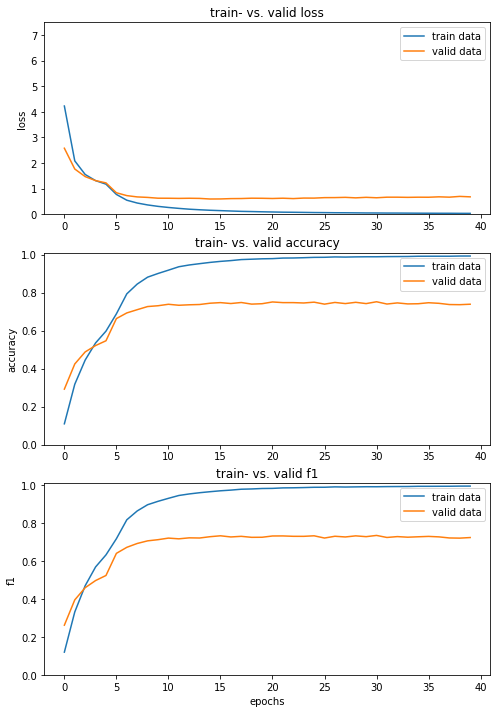

Training succeeded in 98491.328s


In [15]:
if __name__=="__main__":
    main()
